In [1]:
import warnings
warnings.filterwarnings('ignore')

In [58]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

from os import listdir
from sklearn.model_selection import train_test_split

import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, MaxPool2D, Conv1D, Conv2D, Dropout, BatchNormalization
from keras.layers import SimpleRNN, LSTM, GRU, MaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils import np_utils

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [186]:
mfcc_files = ['../data/mfcc/5lang_10mfcc_022821/' + f for f in listdir('../data/mfcc/5lang_10mfcc_022821/') if 'mfcc.pkl' in f]
target_files = ['../data/target/' + f for f in listdir('../data/target/') if 'target.pkl' in f]

mfcc_files.sort()
target_files.sort()

In [187]:
def reload(path):
    with open(path, 'rb') as f:
        return pickle.load(f)

In [188]:
mfcc_reloaded = [reload(f) for f in mfcc_files]
target_reloaded = [reload(f) for f in target_files]

In [189]:
mfcc_files

['../data/mfcc/5lang_10mfcc_022821/en_12130n_10mfcc.pkl',
 '../data/mfcc/5lang_10mfcc_022821/es_11763n_10mfcc.pkl',
 '../data/mfcc/5lang_10mfcc_022821/fr_10894n_10mfcc.pkl',
 '../data/mfcc/5lang_10mfcc_022821/ru_11848n_10mfcc.pkl',
 '../data/mfcc/5lang_10mfcc_022821/zh_11067n_10mfcc.pkl']

In [190]:
target_files

['../data/target/en_12130n_target.pkl',
 '../data/target/es_11763n_target.pkl',
 '../data/target/fr_10894n_target.pkl',
 '../data/target/ru_11848n_target.pkl',
 '../data/target/zh_11067n_target.pkl']

In [200]:
X = np.concatenate(mfcc_reloaded)

In [192]:
y = np.concatenate(target_reloaded)

In [193]:
# https://machinelearningmastery.com/multi-class-classification-tutorial-keras-deep-learning-library/
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(y)
encoded_y = encoder.transform(y)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_y)

In [194]:
# X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)

In [220]:
X_train, X_test, y_train, y_test = train_test_split(X, dummy_y)

In [202]:
from tensorflow.keras.layers import Bidirectional

In [246]:
model = Sequential()
model.add(BatchNormalization())
# model.add(Bidirectional(GRU(16)))
# model.add(Bidirectional(SimpleRNN(128, input_shape = (10, 157, 1))))
model.add(GRU(64, return_sequences = True))
model.add(GRU(64, return_sequences = True))
model.add(GRU(64))
model.add(Flatten())
model.add(Dropout(.2))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(.2))
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(.2))
model.add(Dense(32, activation = 'relu'))
model.add(Dropout(.2))
model.add(Dense(5, activation = 'softmax'))
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc'])

In [247]:
earlystop = EarlyStopping(patience=5)

In [248]:
history = model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_test, y_test),
    callbacks=[earlystop],
    epochs=50
)

Epoch 1/50
1353/1353 [==============================] - 22s 14ms/step - loss: 1.5160 - acc: 0.3006 - val_loss: 1.1880 - val_acc: 0.5167
Epoch 2/50
1353/1353 [==============================] - 18s 14ms/step - loss: 1.1678 - acc: 0.5282 - val_loss: 0.9514 - val_acc: 0.6299
Epoch 3/50
1353/1353 [==============================] - 18s 13ms/step - loss: 1.0087 - acc: 0.6093 - val_loss: 0.8396 - val_acc: 0.6739
Epoch 4/50
1353/1353 [==============================] - 18s 14ms/step - loss: 0.8805 - acc: 0.6683 - val_loss: 0.7848 - val_acc: 0.7030
Epoch 5/50
1353/1353 [==============================] - 18s 14ms/step - loss: 0.8211 - acc: 0.6964 - val_loss: 0.7428 - val_acc: 0.7231
Epoch 6/50
1353/1353 [==============================] - 18s 13ms/step - loss: 0.7501 - acc: 0.7232 - val_loss: 0.7140 - val_acc: 0.7317
Epoch 7/50
1353/1353 [==============================] - 19s 14ms/step - loss: 0.6995 - acc: 0.7423 - val_loss: 0.6709 - val_acc: 0.7493
Epoch 8/50
1353/1353 [==========================

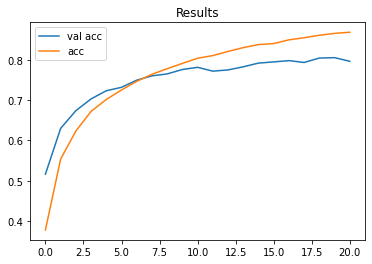

In [249]:
# plot
plt.plot(history.history['val_acc'], label = 'val acc')
plt.plot(history.history['acc'], label = 'acc')
plt.legend()
plt.title('Results');

In [257]:
split = (X_train, X_test, y_train, y_test)
with open('../models/5l10m_arrays.pkl', 'wb') as f:
    pickle.dump(split, f)

In [255]:
model.save('../models/5lang_10mfcc_022821.h5', save_format='h5')

In [17]:
# reloaded_model = tensorflow.keras.models.load_model('../models/cnn02252021.h5')

In [250]:
y_out = np.apply_along_axis(np.argmax, axis=1, arr=y_test)

In [251]:
cm = confusion_matrix(y_out, model.predict_classes(X_test))

In [252]:
cm

array([[2349,  194,  123,  178,  191],
       [ 253, 2379,   61,  221,   88],
       [ 185,   88, 2204,  182,  108],
       [ 181,  268,  123, 2206,   96],
       [ 169,  103,   49,   81, 2346]])

In [301]:
x = np.true_divide(cm.T, cm.T.sum(axis=0, keepdims=True))

Text(69.0, 0.5, 'Predicted')

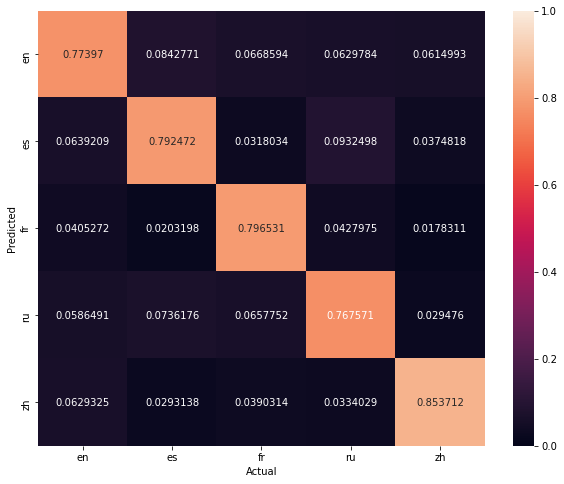

In [302]:
plt.figure(figsize=(10, 8))
sns.heatmap(x, annot=True, vmin=0, vmax=1, fmt='g', xticklabels=['en', 'es', 'fr', 'ru', 'zh'], yticklabels=['en', 'es', 'fr', 'ru', 'zh'])
plt.xlabel("Actual")
plt.ylabel("Predicted")

In [275]:
mfcc_val = ['../data/mfcc/validation/' + f for f in listdir('../data/mfcc/validation/') if 'mfcc.pkl' in f]
target_val = ['../data/target/validation/' + f for f in listdir('../data/target/validation/') if 'target.pkl' in f]

mfcc_val.sort()
target_val.sort()

mfcc_val_reloaded = [reload(f) for f in mfcc_val]
target_val_reloaded = [reload(f) for f in target_val]

X_val = np.concatenate(mfcc_val_reloaded)
y_val = np.concatenate(target_val_reloaded)

# encode class values as integers
encoded_y_val = encoder.transform(y_val)

In [285]:
target_val

['../data/target/validation/en_150n_target.pkl',
 '../data/target/validation/es_122n_target.pkl',
 '../data/target/validation/fr_127n_target.pkl',
 '../data/target/validation/ru_71n_target.pkl',
 '../data/target/validation/zh_96n_target.pkl']

In [286]:
target_val_reloaded

[array(['en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en',
        'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en',
        'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en',
        'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en',
        'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en',
        'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en',
        'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en',
        'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en',
        'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en',
        'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en',
        'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en',
        'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en',
        'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en',
        'en', 'en', 'en', 'en', 'en', 

In [290]:
cm_val.T

array([[ 12,  22,  11,   4,   3],
       [  0,   2,   2,   0,   0],
       [  1,  10,   0,  20,   0],
       [134,  66, 113,  27,  92],
       [  3,  22,   1,  20,   1]])

Text(69.0, 0.5, 'Predicted')

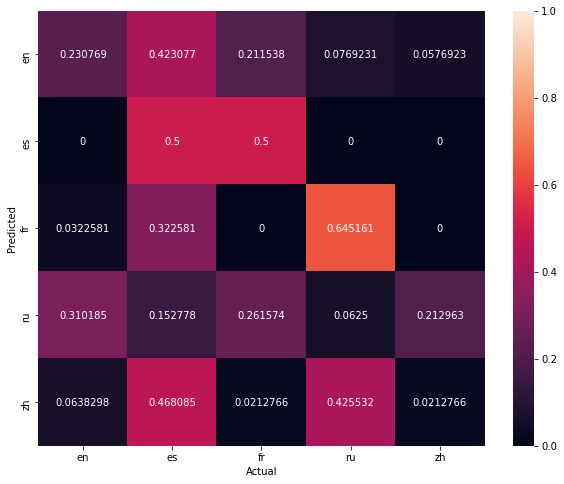

In [291]:
cm_val = confusion_matrix(encoded_y_val, model.predict_classes(X_val))
cm_val_norm = np.true_divide(cm_val.T, cm_val.T.sum(axis=1, keepdims=True))
plt.figure(figsize=(10, 8))
sns.heatmap(cm_val_norm, annot=True, vmin=0, vmax=1, fmt='g', xticklabels=['en', 'es', 'fr', 'ru', 'zh'], yticklabels=['en', 'es', 'fr', 'ru', 'zh'])
plt.xlabel("Actual")
plt.ylabel("Predicted")

In [300]:
encoder.classes_

array(['en', 'es', 'fr', 'ru', 'zh'], dtype='<U2')

In [295]:
model.predict_classes(mfcc_val_reloaded[0])

array([3, 3, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 4, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 2, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 0, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 4, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 0, 0, 3, 3, 3, 3, 3, 4, 0, 0, 3, 3, 3])

In [296]:
model.predict_classes(mfcc_val_reloaded[1])

array([3, 3, 3, 3, 3, 4, 3, 4, 3, 3, 3, 2, 3, 3, 4, 3, 0, 4, 4, 4, 4, 3,
       1, 1, 3, 4, 4, 0, 4, 2, 3, 3, 2, 0, 3, 0, 4, 3, 3, 0, 2, 3, 3, 4,
       3, 2, 3, 0, 0, 3, 3, 3, 0, 4, 3, 3, 4, 4, 3, 3, 4, 4, 3, 3, 3, 3,
       3, 0, 3, 3, 3, 3, 0, 2, 3, 0, 4, 3, 3, 3, 0, 4, 3, 0, 3, 3, 3, 3,
       2, 0, 3, 2, 2, 3, 3, 3, 3, 0, 0, 3, 2, 3, 3, 3, 4, 0, 3, 3, 3, 0,
       0, 3, 3, 3, 0, 3, 0, 0, 4, 4, 3, 3])

In [297]:
model.predict_classes(mfcc_val_reloaded[2])

array([0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 1, 3, 3, 3, 3, 0, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 3, 3, 3, 3, 0, 3, 0, 3, 3, 3, 3,
       3, 3, 3, 4, 3, 3, 3, 3, 0, 3, 3, 0, 3, 3, 3, 3, 3])

In [298]:
model.predict_classes(mfcc_val_reloaded[3])

array([4, 2, 2, 4, 3, 4, 3, 4, 3, 2, 0, 3, 2, 3, 2, 2, 3, 2, 4, 4, 4, 2,
       2, 3, 3, 4, 2, 0, 3, 2, 2, 3, 3, 3, 3, 2, 2, 3, 3, 4, 2, 3, 4, 0,
       4, 3, 4, 4, 3, 2, 2, 0, 4, 2, 3, 3, 3, 4, 3, 4, 2, 2, 4, 3, 3, 4,
       4, 4, 3, 3, 3])

In [299]:
model.predict_classes(mfcc_val_reloaded[4])

array([3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       4, 3, 0, 3, 3, 3, 3, 3])